<a href="https://colab.research.google.com/github/dilekcelik/Sainsbury-Predicting-Probability-of-Product-Discontinuation/blob/main/notebooks/Sainsbury_EndToEnd_by_DilekCelik_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAINSBURY - MACHINE LEARNING MODELS TO PREDICT PROBABILITY OF “discontinued”
**Author:** Dr Dilek Celik

# Table of Contents

1.  Business Context
2.  Requirements
3.  Import Libraries
4.  Data Connection
5.  First Look at the Datasets
6.  Merge Tables
7.  Exploratory Data Analysis (EDA)
8.  Aggregation and Lagged CatEdition - Product-level snapshot per catalogue edition
9. Explore Lagged Data
10. Correlation
11. DiscontinuedTF Class Imbalance Check
12. Check Missing
13. Imputation of Missing with MICE
14. Outliers
15. Train Test Split for Timeseries - WalkForward
16. Apply SMOTE to X_train and y_train
17. Scaling
18. Pipeline Lagged
19. ROC/AUC Graph Function
20. Logistic Regression Pipeline
21. XGBOOST Pipeline
22. LightGBM Pipeline
23. CatBoost Pipeline
24. Comparing Models' Performance and Evaluation Metrics
25. Brier Score Plot
26. Feature Importance
27. SHAP - Explainability
28. Cost-Based Threshold
29. Deployment - Test Case
30. Future Roadmap for the Project

### **BUSINESS CONTEXT**
---
- Argos publishes a new **product catalogue twice per year**.
- During each **range refresh**, ~30% of products are replaced.
- The replenishment team must decide:
  - Which products to **keep in stock**.
  - Which products to **phase out**.
- Wrong decisions are costly:
  - **Lost sales** → if we wrongly stop stocking a good product.
  - **Clearance losses** → if we overstock a product that gets discontinued.

This model predicts discontinuation risk **at any given point in time**, enabling **data-driven** replenishment.

---

### **STEPS TO CREATING MODELS**
---
# 📘 Overview

Every catalogue edition, Argos conducts a **range refresh**: some products are retained, others are discontinued.  
This notebook develops a machine learning pipeline to **predict, before a new catalogue edition, which products will be discontinued**.  

The goal is to support the replenishment team with better:  
- Stock planning  
- Supplier negotiations  
- Reduction of excess inventory for products near discontinuation  

---

# 🔹 Step 1. Load Raw Data

We begin by reading in the raw source data:  

- `ProductDetails.csv` contains weekly product-level attributes such as price, forecasts, and actual sales.  
- `CatalogueDiscontinuation.csv` indicates whether a product was discontinued in a given edition.  

This gives us the **granular historical record** needed for modeling.  

# 🔹 Step 2. Merge Datasets

The raw product details and discontinuation records are merged into a single dataset.  
This dataset is indexed by **`ProductKey`** and **`CatEdition`**, giving us one row per product per catalogue edition.

👉 **Why?**  
Predicting discontinuation requires both:  
- **Input features** → weekly sales, forecasts, price, product attributes  
- **Target labels** → discontinued or not in that catalogue  

Merging ensures that each product-edition has both its **behavioural features** and its **discontinuation outcome** aligned in one dataset.  

# 🔹 Step 3. Feature Engineering

We transform the weekly dataset into **catalogue-level product features**.

- **Numeric features** (Price, Forecast, Actual sales) → aggregated using *mean, min, max* across weeks.  
- **Categorical features** (Supplier, hierarchy levels, DI/DOM, status, seasonal flags) → summarised with the *most frequent (mode)*
- **Sales trend (SalesSlope)** → computed as the slope of sales over weeks using linear regression (`np.polyfit`).  
- **Lagged target (`Target_Next`)** → for edition *t*, the label is whether the product is discontinued in *t+1*.  

👉 **Why?**  
This step converts detailed weekly data into **compact, predictive signals** at the product–catalogue level.  


# 🔹 Step 4. Walk-Forward Train/Test Split

Since catalogue editions are **time-ordered**, we cannot use random train/test splits.  
Instead, we apply **walk-forward validation**:

- Train on all catalogue editions up to cutoff *t*  
- Test on edition *t+1*  
- Repeat this process across catalogue history  

👉 **Why?**  
Random splits would leak future catalogue data into training, giving overly optimistic results.  
Walk-forward mimics **real deployment**, where only past data is available to forecast the next catalogue.  


# 🔹 Step 5. Scaling Features

We standardize the numerical features to have **mean = 0** and **standard deviation = 1**.  

👉 **Why?**  
- Models such as **Logistic Regression** and **Neural Networks** are sensitive to feature scales — scaling prevents certain features from dominating due to larger numeric ranges.  
- Tree-based models like **XGBoost** are scale-invariant, but we still apply scaling for consistency across the pipeline.  
- This ensures that any future experiments with non-tree models are not biased by unscaled features.  

# 🔹 Step 6. Handle Class Imbalance (Optional)

Our dataset is **imbalanced**: more products are retained than discontinued.  
If left untreated, models may become biased toward predicting the majority class (retained).  

👉 **Options for handling imbalance**:  
1. **XGBoost’s `scale_pos_weight`**  
   - Adjusts the loss function to give more weight to the minority class (discontinued).  
   - Simple and effective for gradient boosting.  

2. **SMOTE (Synthetic Minority Oversampling Technique)**  
   - Creates synthetic samples of the minority class.  
   - Can help models learn decision boundaries better.  

In this project, the discontinuation rate (~30–35%) is not extremely low, so we primarily rely on **`scale_pos_weight`** inside XGBoost.  
SMOTE remains optional for experimentation.  
# 🔹 Step 7. Model Training & Evaluation

We now train a machine learning model (e.g., **XGBoost**) using the engineered features.  

👉 **Evaluation Metrics**  
Because the dataset is imbalanced, we focus on metrics that go beyond simple accuracy:  

- **F1 Score** → balances precision and recall (key for imbalanced datasets).  
- **ROC-AUC** → ability to separate discontinued vs retained across thresholds.  
- **PR-AUC** → precision–recall tradeoff, more informative under imbalance.  
- **Confusion Matrix** → shows false positives (predicting discontinue when retained) and false negatives (missing actual discontinuations).  

👉 **Why F1 instead of accuracy?**  
Accuracy can be misleading when classes are imbalanced.  
F1 ensures we capture discontinued products while limiting false alarms.  
# 🔹 Step 8. Interpretation & Next Steps

### 📊 Results Observed
- **Random Train/Test Split**  
  - F1 ≈ 0.86, ROC-AUC ≈ 0.95  
  - Likely **optimistic** due to information leakage (future catalogues included in training).  

- **Walk-Forward Validation**  
  - F1 ≈ 0.76, ROC-AUC ≈ 0.74  
  - More **realistic** since it respects the chronological order of catalogues.  
  - This is a stronger baseline for deployment.  

---

### 🔑 Business Interpretation
- The model successfully identifies many discontinued products ahead of time.  
- High recall ensures fewer discontinued products are missed (important for stock reduction).  
- Precision can be tuned with thresholds to control false alarms (predicting discontinuation incorrectly).  

---

### 🚀 Next Steps & Improvements
1. **Additional Features**  
   - Product "age" (how many catalogue editions survived).  
   - Relative performance (sales vs. category average).  
   - Supplier history (how often suppliers’ products are discontinued).  

2. **Model Enhancements**  
   - Hyperparameter tuning of XGBoost (`max_depth`, `colsample_bytree`, `subsample`).  
   - Try ensemble alternatives like **LightGBM** or **CatBoost**.  
   - Stacking models (combine tree + logistic regression).  

3. **Evaluation**  
   - Calibrate decision thresholds (optimize for business objectives).  
   - Monitor model drift as new catalogues are released.  


## REQUIREMENTS
- python 3.0+
- xgboost>=2.0.0
- scikit-learn>=1.3.0
- pandas>=2.0.0
- numpy>=1.24.0

## IMPORT LIBRARIES

In [ ]:
#!pip install imblearn
#!pip install xgboost
#!pip install nbdev

In [ ]:
# Import libraries
import os

import pandas as pd
import numpy as np

# pprint
import pprint

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Inline
%matplotlib inline

# Display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Train-test split
from sklearn.model_selection import train_test_split

# Smote
from imblearn.over_sampling import SMOTE
# SmoteTomek
from imblearn.combine import SMOTETomek
# Adasyn
from imblearn.over_sampling import ADASYN

# Scaling
from sklearn.preprocessing import StandardScaler

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Parameter Tuning and Validation
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Evaluation Metrics
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    f1_score, roc_auc_score, log_loss, brier_score_loss,
    average_precision_score
)
# Ensemble Method
from sklearn.ensemble import VotingClassifier

## DATA CONNECTION

- Load `ProductDetails.csv` and `CatalogueDiscontinuation.csv`.
- Centralize `DATA_DIR`, set explicit dtypes, assert required columns.
- Clean `df_productdetails`, `df_cataloguediscontinuation` with row/column logs.


In [ ]:
# I located the data in my Groogle Drive. This is how I accessed to it.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to Train Data
DATA_DIR = "/content/drive/MyDrive/Product_Discontinuation_Interview_Task"
# Read Training Data
df_productdetails = pd.read_csv(os.path.join(DATA_DIR, "ProductDetails.csv"))
df_cataloguediscontinuation = pd.read_csv(os.path.join(DATA_DIR, "CatalogueDiscontinuation.csv"))

## FIRST LOOK AT THE DATASETS

In [ ]:
df_productdetails.head()

,ProductKey,Supplier,HierarchyLevel1,HierarchyLevel2,DIorDOM,Seasonal
0,30437,13194,80445,28611,DOM,False
1,68587,13194,80445,28611,DOM,False
2,46645,13194,80445,28611,DOM,False
3,49343,13194,80445,28611,DOM,False
4,64223,13194,80445,28611,DOM,False


In [ ]:
# Number of unique products by key
df_productdetails['ProductKey'].nunique()

77372

In [ ]:
df_productdetails.shape

(77372, 6)

In [ ]:
df_cataloguediscontinuation.head()

,CatEdition,SpringSummer,ProductKey,WeeksOut,Status,SalePriceIncVAT,ForecastPerWeek,ActualsPerWeek,DiscontinuedTF
0,89,True,8108,-11,RI,43.99,250.545,248.642,False
1,89,True,8108,-10,RI,43.99,255.700,244.333,False
2,89,True,8108,-9,RI,43.99,206.111,252.187,False
3,89,True,8108,-8,RI,43.99,188.625,254.764,False
4,89,True,8108,-7,RI,43.99,169.142,249.000,False


In [ ]:
df_cataloguediscontinuation.shape

(3625659, 9)

In [ ]:
df_cataloguediscontinuation['ProductKey'].nunique()

70227

## MERGE TABLES

🔑 **Why this merge is good:**

**Justifications:**

Start from **`df_cataloguediscontinuation`**:

* Since `df_cataloguediscontinuation` is the largest table

**Use right join:**

*  Keeps all df_cataloguediscontinuation rows intact.

**Dropping id:**

* After merging with df_productdetails, we don’t need second ProductKey so dropping ProductKey avoids redundancy.


In [ ]:
#| Extract
# This function merges the tables
def build_product_dataset(df_productdetails: pd.DataFrame,
                          df_cataloguediscontinuation: pd.DataFrame) -> pd.DataFrame:
    """
    Merge discount data with product details.

    Parameters
    ----------
    df_productdetails : pd.DataFrame
        Product details dataset
    df_cataloguediscontinuation : pd.DataFrame
        Discount dataset

    Returns
    -------
    pd.DataFrame
        Merged dataset
    """

    # Defensive copy
    df_productdetails = df_productdetails.copy()
    df_cataloguediscontinuation = df_cataloguediscontinuation.copy()

    # --- Merge discount into product details ---
    merged = df_productdetails.merge(
        df_cataloguediscontinuation, on="ProductKey", how="right"
    )

    return merged

df = build_product_dataset(df_productdetails, df_cataloguediscontinuation)

In [ ]:
df.head(2)

,ProductKey,Supplier,HierarchyLevel1,HierarchyLevel2,DIorDOM,Seasonal,CatEdition,SpringSummer,WeeksOut,Status,SalePriceIncVAT,ForecastPerWeek,ActualsPerWeek,DiscontinuedTF
0,8108,78589,67967,32668,DOM,False,89,True,-11,RI,43.99,250.545,248.642,False
1,8108,78589,67967,32668,DOM,False,89,True,-10,RI,43.99,255.700,244.333,False


In [ ]:
df.shape

(3625659, 14)

## EXPLORATORY DATA ANALYSIS (EDA)

- **Goal:** Understand features and categories


In [ ]:
df.shape

(3625659, 14)

In [ ]:
df['ProductKey'].nunique()

70227

In [ ]:
# Number of unique suppliers
df['Supplier'].nunique()

1405

In [ ]:
# Number of unique WeeksOut
df['WeeksOut'].nunique()

24

In [ ]:
df.columns

Index(['ProductKey', 'Supplier', 'HierarchyLevel1', 'HierarchyLevel2',
       'DIorDOM', 'Seasonal', 'CatEdition', 'SpringSummer', 'WeeksOut',
       'Status', 'SalePriceIncVAT', 'ForecastPerWeek', 'ActualsPerWeek',
       'DiscontinuedTF'],
      dtype='object')

In [ ]:
# Checking all data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3625659 entries, 0 to 3625658
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   ProductKey       int64  
 1   Supplier         int64  
 2   HierarchyLevel1  int64  
 3   HierarchyLevel2  int64  
 4   DIorDOM          object 
 5   Seasonal         bool   
 6   CatEdition       int64  
 7   SpringSummer     bool   
 8   WeeksOut         int64  
 9   Status           object 
 10  SalePriceIncVAT  float64
 11  ForecastPerWeek  float64
 12  ActualsPerWeek   float64
 13  DiscontinuedTF   bool   
dtypes: bool(3), float64(3), int64(6), object(2)
memory usage: 314.7+ MB


In [ ]:
df.head()

,ProductKey,Supplier,HierarchyLevel1,HierarchyLevel2,DIorDOM,Seasonal,CatEdition,SpringSummer,WeeksOut,Status,SalePriceIncVAT,ForecastPerWeek,ActualsPerWeek,DiscontinuedTF
0,8108,78589,67967,32668,DOM,False,89,True,-11,RI,43.99,250.545,248.642,False
1,8108,78589,67967,32668,DOM,False,89,True,-10,RI,43.99,255.700,244.333,False
2,8108,78589,67967,32668,DOM,False,89,True,-9,RI,43.99,206.111,252.187,False
3,8108,78589,67967,32668,DOM,False,89,True,-8,RI,43.99,188.625,254.764,False
4,8108,78589,67967,32668,DOM,False,89,True,-7,RI,43.99,169.142,249.000,False


In [ ]:
# Checking categories in Status column
df['Status'].unique()

array(['RI', 'RO'], dtype=object)

In [ ]:
# Checking categories in DIorDOM column
df['DIorDOM'].unique()

array(['DOM', 'DI'], dtype=object)

In [ ]:
# Checking categories in WeeksOut
df['WeeksOut'].unique()

array([-11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1, -24, -23,
       -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12])

In [ ]:
df['CatEdition'].unique()

array([89, 90, 91, 92, 88, 93, 94])

In [ ]:
df['Supplier'].nunique()

1405

In [ ]:
df['HierarchyLevel1'].nunique()

214

In [ ]:
df['HierarchyLevel2'].nunique()

28

In [ ]:
# Checking dublicates
df.duplicated().sum()

np.int64(0)

In [ ]:
# Exploring how many rows of data we have for each product using ProductKey
df[df['ProductKey']==8108]

,ProductKey,Supplier,HierarchyLevel1,HierarchyLevel2,DIorDOM,Seasonal,CatEdition,SpringSummer,WeeksOut,Status,SalePriceIncVAT,ForecastPerWeek,ActualsPerWeek,DiscontinuedTF
0,8108,78589,67967,32668,DOM,False,89,True,-11,RI,43.99,250.545,248.642,False
1,8108,78589,67967,32668,DOM,False,89,True,-10,RI,43.99,255.700,244.333,False
2,8108,78589,67967,32668,DOM,False,89,True,-9,RI,43.99,206.111,252.187,False
3,8108,78589,67967,32668,DOM,False,89,True,-8,RI,43.99,188.625,254.764,False
4,8108,78589,67967,32668,DOM,False,89,True,-7,RI,43.99,169.142,249.000,False
5,8108,78589,67967,32668,DOM,False,89,True,-6,RI,43.99,160.666,244.473,False
6,8108,78589,67967,32668,DOM,False,89,True,-5,RI,43.99,138.200,251.750,False
7,8108,78589,67967,32668,DOM,False,89,True,-4,RI,43.99,122.500,255.714,False
8,8108,78589,67967,32668,DOM,False,89,True,-3,RI,43.99,89.333,249.727,False
9,8108,78589,67967,32668,DOM,False,89,True,-2,RI,43.99,85.000,242.043,False


## AGGREGATION AND LAGGED CATEDITION - Product-level snapshot per catalogue edition

### 🔹 Function Summary: `preprocess_product_data`

This function transforms **weekly product-level data** into a **catalogue-edition-level dataset** for predicting **product discontinuation**.  

---

### 1. Grouping by ProductKey + CatEdition
- Each row in the final dataset represents **one product in one catalogue edition**.  
- **Why?**  
  The business question is:  
  *“Will this product be discontinued in the next catalogue?”*  
  → The catalogue edition is the natural unit of prediction.  

---

### 2. Numeric Feature Aggregation
**Columns:**  
- `SalePriceIncVAT`  
- `ForecastPerWeek`  
- `ActualsPerWeek`  

**Aggregations:**  
- Mean → captures typical behavior.  
- Min → lowest observed value.  
- Max → highest observed value.  

**Why?**  
These summarize both **central tendency** and **extremes**, giving a fuller picture of product performance across weeks in a catalogue.  

---

### 3. Categorical Feature Aggregation
**Columns:**  
- `Supplier`, `HierarchyLevel1`, `HierarchyLevel2`, `DIorDOM`, `Seasonal`, `SpringSummer`, `Status`  

**Aggregation:**  
- Mode (most frequent value) within each product-edition.  

**Why?**  
Most of these are **stable attributes** (e.g., supplier, category). If multiple values occur, the most frequent is the most representative.  

---

### 4. Sales Trend Feature
- **Feature:** `SalesSlope`  
- Computed using **np.polyfit** on `ActualsPerWeek` vs. `WeeksOut`.  

**Why?**  
- Positive slope → sales increasing → likely to be retained.  
- Negative slope → sales declining → higher risk of discontinuation.  

This provides a compact measure of sales trajectory within a catalogue.  

---

### 5. Target Variable Creation
- **Feature:** `Target_Next`  
- Constructed by **lagging the discontinuation flag forward**:  
  For edition *t*, the target is whether the product is discontinued in edition *t+1*.  
- Note: A product that only lasts 1 edition will give us 0 row (because there’s no “next” edition to assign Target_Next).
**Why?**  
- Matches the real business case: predicting **future** discontinuation.  
- Avoids leakage (not using current discontinuation status to predict itself).  

---

### 6. Encoding
- Convert booleans (`Seasonal`, `SpringSummer`) → integers (0/1).  
- Encode categorical IDs (`Supplier`, `HierarchyLevel1`, `HierarchyLevel2`, `DIorDOM`, `Status`) → integers using label encoding.  

**Why?**  
ML models require numeric inputs. Encoding ensures categorical attributes are usable in models like XGBoost and LightGBM.  

---

### 7. Final Dataset
Each row contains:  
- Aggregated numeric stats (mean, min, max).  
- Encoded categorical features.  
- Sales trend slope.  
- Target variable (`Target_Next`).  

**Why?**  
This structure is compact, predictive, and avoids information leakage — ready for supervised ML training.  

---

✅ **In short:**  
The function converts noisy weekly sales data into **predictive catalogue-level features**, adds a **future discontinuation label**, and ensures all variables are in numeric form suitable for ML models.  


In [ ]:
df.columns

Index(['ProductKey', 'Supplier', 'HierarchyLevel1', 'HierarchyLevel2',
       'DIorDOM', 'Seasonal', 'CatEdition', 'SpringSummer', 'WeeksOut',
       'Status', 'SalePriceIncVAT', 'ForecastPerWeek', 'ActualsPerWeek',
       'DiscontinuedTF'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3625659 entries, 0 to 3625658
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   ProductKey       int64  
 1   Supplier         int64  
 2   HierarchyLevel1  int64  
 3   HierarchyLevel2  int64  
 4   DIorDOM          object 
 5   Seasonal         bool   
 6   CatEdition       int64  
 7   SpringSummer     bool   
 8   WeeksOut         int64  
 9   Status           object 
 10  SalePriceIncVAT  float64
 11  ForecastPerWeek  float64
 12  ActualsPerWeek   float64
 13  DiscontinuedTF   bool   
dtypes: bool(3), float64(3), int64(6), object(2)
memory usage: 314.7+ MB


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def preprocess_product_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess product-week dataset into product+CatEdition level features
    and labels for discontinuation prediction.

    Steps:
    1. Aggregate numeric + categorical features at ProductKey+CatEdition level.
    2. Compute sales slope (trend) from WeeksOut vs ActualsPerWeek (via np.polyfit).
    3. Create Target_Next (discontinued in next CatEdition).
    4. Encode categorical/static columns.
    """

    # --- Define columns ---
    cat_cols = [
        "Supplier", "HierarchyLevel1", "HierarchyLevel2",
        "DIorDOM", "Seasonal", "SpringSummer", "Status"
    ]
    num_cols = ["SalePriceIncVAT", "ForecastPerWeek", "ActualsPerWeek"]

    # --- Aggregation functions ---
    agg_funcs = {col: ['mean', 'min', 'max'] for col in num_cols}
    for col in cat_cols:
        agg_funcs[col] = lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]

    # --- Aggregate features ---
    features = (
        df.groupby(['ProductKey', 'CatEdition'])
          .agg(agg_funcs)
    )
    features.columns = [
        f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col
        for col in features.columns
    ]
    features = features.reset_index()

    # --- Compute SalesSlope (trend) with np.polyfit ---
    slopes = (
    df.groupby(['ProductKey', 'CatEdition'])
      .apply(lambda g: np.polyfit(g['WeeksOut'], g['ActualsPerWeek'], 1)[0]
             if g['WeeksOut'].nunique() > 1 else 0.0)
      .reset_index(name="SalesSlope")
    )

    features = features.merge(slopes, on=['ProductKey', 'CatEdition'], how='left')

    # --- Create labels ---
    labels = (
        df.groupby(['ProductKey', 'CatEdition'])['DiscontinuedTF']
          .max()
          .reset_index()
    )
    labels['Target_Next'] = labels.groupby('ProductKey')['DiscontinuedTF'].shift(-1)
    labels = labels.drop(columns=['DiscontinuedTF'])

    # --- Merge features + labels ---
    dataset = features.merge(labels, on=['ProductKey', 'CatEdition'], how='inner')
    dataset = dataset.dropna(subset=['Target_Next'])
    dataset['Target_Next'] = dataset['Target_Next'].astype(int)

    # --- Encoding ---
    # Convert booleans to int
    for col in ['Seasonal_<lambda>', 'SpringSummer_<lambda>']:
        if col in dataset.columns:
            dataset[col] = dataset[col].astype(int)

    # Label encode categorical ID columns
    encode_cols = [
        'Supplier_<lambda>', 'HierarchyLevel1_<lambda>', 'HierarchyLevel2_<lambda>',
        'DIorDOM_<lambda>', 'Status_<lambda>'
    ]
    for col in encode_cols:
        if col in dataset.columns:
            le = LabelEncoder()
            dataset[col] = le.fit_transform(dataset[col])

    # --- Clean column names ---
    dataset = dataset.rename(columns=lambda x: x.replace("<lambda>", "mode"))
    dataset.columns = dataset.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

    return dataset


# run
dataset = preprocess_product_data(df)
dataset.head()

/tmp/ipython-input-3662380937.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.polyfit(g['WeeksOut'], g['ActualsPerWeek'], 1)[0]


,ProductKey,CatEdition,SalePriceIncVAT_mean,SalePriceIncVAT_min,SalePriceIncVAT_max,ForecastPerWeek_mean,ForecastPerWeek_min,ForecastPerWeek_max,ActualsPerWeek_mean,ActualsPerWeek_min,ActualsPerWeek_max,Supplier_mode,HierarchyLevel1_mode,HierarchyLevel2_mode,DIorDOM_mode,Seasonal_mode,SpringSummer_mode,Status_mode,SalesSlope,Target_Next
3,5,90,18.99,18.99,18.99,4.936000,0.750,12.833,0.212500,0.0,0.375,662,60,11,1,0,0,0,0.088257,1
4,5,91,18.99,18.99,18.99,12.261522,2.434,41.923,4.252826,0.0,8.000,662,60,11,1,0,1,0,0.331338,0
5,5,92,18.99,18.99,18.99,7.083958,5.227,10.000,5.548417,4.0,6.500,662,60,11,1,0,0,0,-0.003164,0
6,5,93,18.99,18.99,18.99,9.647542,5.333,23.500,3.562208,2.0,6.285,662,60,11,1,0,1,0,0.110613,1
9,7,90,69.99,69.99,69.99,37.074667,30.571,48.000,38.651542,32.0,44.333,1206,155,2,1,0,0,0,-0.061353,0


In [ ]:
df = dataset.copy()

## EXPLORE LAGGED DATA

In [ ]:
df[df['ProductKey']==8108][['CatEdition','Target_Next']].groupby('CatEdition').max()

,Target_Next
CatEdition,
89,0
90,0
91,1


In [ ]:
dataset[dataset['ProductKey']==5]

,ProductKey,CatEdition,SalePriceIncVAT_mean,SalePriceIncVAT_min,SalePriceIncVAT_max,ForecastPerWeek_mean,ForecastPerWeek_min,ForecastPerWeek_max,ActualsPerWeek_mean,ActualsPerWeek_min,ActualsPerWeek_max,Supplier_mode,HierarchyLevel1_mode,HierarchyLevel2_mode,DIorDOM_mode,Seasonal_mode,SpringSummer_mode,Status_mode,SalesSlope,Target_Next
3,5,90,18.99,18.99,18.99,4.936000,0.750,12.833,0.212500,0.0,0.375,662,60,11,1,0,0,0,0.088257,1
4,5,91,18.99,18.99,18.99,12.261522,2.434,41.923,4.252826,0.0,8.000,662,60,11,1,0,1,0,0.331338,0
5,5,92,18.99,18.99,18.99,7.083958,5.227,10.000,5.548417,4.0,6.500,662,60,11,1,0,0,0,-0.003164,0
6,5,93,18.99,18.99,18.99,9.647542,5.333,23.500,3.562208,2.0,6.285,662,60,11,1,0,1,0,0.110613,1


In [ ]:
dataset[dataset['ProductKey']==8108]

,ProductKey,CatEdition,SalePriceIncVAT_mean,SalePriceIncVAT_min,SalePriceIncVAT_max,ForecastPerWeek_mean,ForecastPerWeek_min,ForecastPerWeek_max,ActualsPerWeek_mean,ActualsPerWeek_min,ActualsPerWeek_max,Supplier_mode,HierarchyLevel1_mode,HierarchyLevel2_mode,DIorDOM_mode,Seasonal_mode,SpringSummer_mode,Status_mode,SalesSlope,Target_Next
18006,8108,89,43.99,43.99,43.99,278.400875,83.0,633.750,151.918208,0.000,255.714,1240,134,13,1,0,1,0,14.645587,0
18007,8108,90,32.99,32.99,32.99,29.903792,19.5,49.708,42.966292,33.388,68.000,1240,134,13,1,0,0,0,-1.186965,0
18008,8108,91,23.99,23.99,23.99,29.573875,15.5,37.400,20.652167,12.909,31.428,1240,134,13,1,0,1,0,0.746311,1


In [ ]:
dataset.shape

(108678, 20)

## CORRELATION

- I explore correlation to detect redundancy and potential leakage.
- This step helps us to reduce variance, improve generalization, speed training.
- Spearman correlation; flag |ρ| ≥ 0.9; remove post-event signals.
- Heatmap

In [ ]:
# Run this code after running the pipeline as it uses scaled data. This code explores correlation of all features against target feature.
import pandas as pd
import plotly.express as px
from sklearn.feature_selection import mutual_info_classif

# --- Use scaled training data ---
X = scaled_X_train.copy()
y = y_train.copy()

# --- Compute Pearson correlations ---
correlations = X.corrwith(y)

# Convert to DataFrame
corr_df = correlations.reset_index()
corr_df.columns = ["feature", "correlation"]

# Sort by absolute correlation
corr_df = corr_df.reindex(corr_df["correlation"].abs().sort_values(ascending=False).index)

# --- Plotly Express Bar Chart ---
fig = px.bar(
    corr_df,
    x="correlation",
    y="feature",
    orientation="h",
    title="Feature Correlation with Target (Pearson)",
    color="correlation",
    color_continuous_scale="RdBu",
)

fig.update_layout(
    yaxis=dict(autorange="reversed"),  # largest correlation at top
    xaxis_title="Correlation with Target",
    yaxis_title="Feature"
)

fig.show()


In [ ]:
# Run this code after running the pipeline. This code explores correlation among all features.

import plotly.express as px
# --- Compute correlation matrix ---
corr = X.corr()

# --- Plotly Express Heatmap ---
fig = px.imshow(
    corr,
    text_auto=".2f",           # show correlation values with 2 decimals
    color_continuous_scale="RdBu_r",  # red = positive, blue = negative
    zmin=-1, zmax=1,           # fix color range between -1 and 1
    aspect="auto",             # auto aspect ratio
    title="Feature Correlation Matrix"
)

fig.update_layout(
    width=1200, height=1000,
    xaxis_title="Features",
    yaxis_title="Features"
)

fig.show()


## DiscontinuedTF CLASS IMBALANCE CHECK

### 🎯 Target Distribution and Data Imbalance

The target variable **`Target_Next`** shows a **moderately balanced distribution**:

- **Class 0 (Retained):** 57,131 rows → **52.6%**  
- **Class 1 (Discontinued):** 51,547 rows → **47.4%**  

This corresponds to a ratio of roughly **1.1:1** between the two classes.  

---

### 📌 Interpretation

- The dataset is **not severely imbalanced**.  
- Standard classifiers (e.g., **XGBoost**, **LightGBM**) can usually handle this ratio without special balancing.  
- However, there may still be **slight bias** toward the majority class (*retained*).  

---


In [ ]:
# This function checks for class imbalance in the 'DiscontinuedTF' column
def check_class_imbalance(df, target_col):
    """
    Check class distribution and imbalance for a target column.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe
    target_col : str
        Column name of target variable

    Returns
    -------
    pd.DataFrame
        Count and percentage of each class
    """
    class_counts = df[target_col].value_counts()
    class_percent = df[target_col].value_counts(normalize=True) * 100
    imbalance_df = pd.DataFrame({'count': class_counts, 'percentage': class_percent})
    return imbalance_df

check_class_imbalance(df, 'Target_Next')

,count,percentage
Target_Next,,
0,57131,52.569057
1,51547,47.430943


## CHECK MISSING

In [ ]:
df.isnull().sum()[df.isnull().sum() > 0]

,0


In [ ]:
# This function checks missing values in a DataFrame
def check_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Check for missing values in a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset.

    Returns
    -------
    pd.DataFrame
        Summary of missing values per column, including count and percentage.
    """
    missing_count = df.isna().sum()
    missing_percent = (missing_count / len(df)) * 100

    missing_summary = pd.DataFrame({
        "missing_count": missing_count,
        "missing_percent": missing_percent
    })

    # Only show columns with missing values
    missing_summary = missing_summary[missing_summary["missing_count"] > 0].sort_values(
        by="missing_percent", ascending=False
    )

    return missing_summary

missing_df = check_missing_values(df)
print(missing_df)

Empty DataFrame
Columns: [missing_count, missing_percent]
Index: []


## IMPUTATION OF MISSING WITH MICE

In [ ]:
# This function imputes missing values using the Multiple Imputation by Chained Equations (MICE).
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
def mice_impute(df: pd.DataFrame, numeric_only=True, random_state=42) -> pd.DataFrame:
    """
    Impute missing values using MICE (IterativeImputer).

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset with missing values.
    numeric_only : bool, default True
        If True, only numeric columns will be imputed.
    random_state : int
        Random state for reproducibility.

    Returns
    -------
    pd.DataFrame
        DataFrame with missing values imputed.
    """
    df_imputed = df.copy()

    if numeric_only:
        numeric_cols = df_imputed.select_dtypes(include=['number']).columns
    else:
        numeric_cols = df_imputed.columns  # all columns

    imputer = IterativeImputer(random_state=random_state)
    df_imputed[numeric_cols] = imputer.fit_transform(df_imputed[numeric_cols])

    return df_imputed

# df = mice_impute(df)

## OUTLIERS

In [ ]:
def detect_outliers_iqr(df: pd.DataFrame, cols=None, factor: float = 1.5):
    """
    Detect outliers in numeric columns using the IQR method.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe
    cols : list, optional
        List of column names to check for outliers.
        If None, all numeric columns are used.
    factor : float
        IQR factor (default = 1.5).
        Larger values → fewer outliers flagged.

    Returns
    -------
    outlier_summary : pd.DataFrame
        Summary of outliers per column:
        count of outliers, % of total rows.
    """

    if cols is None:
        cols = df.select_dtypes(include=['int64', 'float64']).columns

    summary = []

    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        summary.append({
            "Column": col,
            "Outlier_Count": outliers.count(),
            "Outlier_%": round(outliers.count() / len(df) * 100, 2)
        })

    return pd.DataFrame(summary)


In [ ]:
df.columns

Index(['ProductKey', 'CatEdition', 'SalePriceIncVAT_mean',
       'SalePriceIncVAT_min', 'SalePriceIncVAT_max', 'ForecastPerWeek_mean',
       'ForecastPerWeek_min', 'ForecastPerWeek_max', 'ActualsPerWeek_mean',
       'ActualsPerWeek_min', 'ActualsPerWeek_max', 'Supplier_mode',
       'HierarchyLevel1_mode', 'HierarchyLevel2_mode', 'DIorDOM_mode',
       'Seasonal_mode', 'SpringSummer_mode', 'Status_mode', 'SalesSlope',
       'Target_Next'],
      dtype='object')

In [ ]:
outlier_report = detect_outliers_iqr(df, cols=['ProductKey', 'CatEdition', 'SalePriceIncVAT_mean',
       'SalePriceIncVAT_min', 'SalePriceIncVAT_max', 'ForecastPerWeek_mean',
       'ForecastPerWeek_min', 'ForecastPerWeek_max', 'ActualsPerWeek_mean',
       'ActualsPerWeek_min', 'ActualsPerWeek_max', 'Supplier_mode',
       'HierarchyLevel1_mode', 'HierarchyLevel2_mode', 'DIorDOM_mode',
       'Seasonal_mode', 'SpringSummer_mode', 'Status_mode', 'SalesSlope',
       'Target_Next'])
print(outlier_report)

                  Column  Outlier_Count  Outlier_%
0             ProductKey              0       0.00
1             CatEdition              0       0.00
2   SalePriceIncVAT_mean          12120      11.15
3    SalePriceIncVAT_min          12118      11.15
4    SalePriceIncVAT_max          12121      11.15
5   ForecastPerWeek_mean          10607       9.76
6    ForecastPerWeek_min          10886      10.02
7    ForecastPerWeek_max          10880      10.01
8    ActualsPerWeek_mean          10162       9.35
9     ActualsPerWeek_min          10791       9.93
10    ActualsPerWeek_max          10257       9.44
11         Supplier_mode              0       0.00
12  HierarchyLevel1_mode              0       0.00
13  HierarchyLevel2_mode              0       0.00
14          DIorDOM_mode              0       0.00
15         Seasonal_mode           7280       6.70
16     SpringSummer_mode              0       0.00
17           Status_mode           9629       8.86
18            SalesSlope       

## TRAIN TEST SPLIT FOR TIMESERIES - WALKFORWARD

Because we’ve lagged the target, we should still treat this as a time-series prediction problem:
* Train on earlier CatEditions (e.g. up to 91)
* Test on later CatEditions (e.g. 92, 93…)

That way, when we train on 91 → target=92, we’re never using future data from edition 92 in training to predict edition 92.

In [ ]:
def walk_forward_split(dataset, feature_drop=['Target_Next', 'ProductKey']):
    cat_editions = sorted(dataset['CatEdition'].unique())

    for cutoff in cat_editions[:-1]:  # leave last edition for unseen future
        train = dataset[dataset['CatEdition'] <= cutoff]
        test  = dataset[dataset['CatEdition'] > cutoff]   # changed here

        X_train = train.drop(columns=feature_drop)
        y_train = train['Target_Next']

        X_test = test.drop(columns=feature_drop)
        y_test = test['Target_Next']

        # Skip if y_test has only 1 class
        if y_test.nunique() < 2:
            print(f"Skipping cutoff {cutoff}: only one class in y_test ({y_test.iloc[0]})")
            continue

        yield cutoff, X_train, y_train, X_test, y_test


In [ ]:
df.head(2)

,ProductKey,CatEdition,SalePriceIncVAT_mean,SalePriceIncVAT_min,SalePriceIncVAT_max,ForecastPerWeek_mean,ForecastPerWeek_min,ForecastPerWeek_max,ActualsPerWeek_mean,ActualsPerWeek_min,ActualsPerWeek_max,Supplier_mode,HierarchyLevel1_mode,HierarchyLevel2_mode,DIorDOM_mode,Seasonal_mode,SpringSummer_mode,Status_mode,SalesSlope,Target_Next
3,5,90,18.99,18.99,18.99,4.936000,0.750,12.833,0.212500,0.0,0.375,662,60,11,1,0,0,0,0.088257,1
4,5,91,18.99,18.99,18.99,12.261522,2.434,41.923,4.252826,0.0,8.000,662,60,11,1,0,1,0,0.331338,0


In [ ]:
for cutoff, X_train, y_train, X_test, y_test in walk_forward_split(df):
    print(f"Train up to {cutoff}, test on {cutoff+1}: "
          f"Train size {len(X_train)}, Test size {len(X_test)}")


## APPLY SMOTE TO X_train and y_train

In [ ]:
# This function applies SMOTE to solve class imbalance issue.
from imblearn.over_sampling import SMOTE

def apply_smote(X_train, y_train, random_state=42):
    """
    Apply SMOTE oversampling to balance the classes in the training set.

    Parameters
    ----------
    X_train : pd.DataFrame or np.array
        Feature training set
    y_train : pd.Series or np.array
        Target training set
    random_state : int
        Random seed for reproducibility

    Returns
    -------
    X_res, y_res : np.array
        Resampled features and target
    """
    smote = SMOTE(sampling_strategy=0.3, random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)
    return X_res, y_res

## SCALING

In [ ]:
from sklearn.preprocessing import StandardScaler
import joblib
def scale_features(X_train: pd.DataFrame,
                   X_test: pd.DataFrame) -> tuple:
    """
    Convert datetime columns into numeric features and scale all features.

    Parameters
    ----------
    X_train : pd.DataFrame
        Training feature set
    X_test : pd.DataFrame
        Testing feature set
    date_cols : list, optional
        List of datetime columns to convert (e.g., ['originationDate'])

    Returns
    -------
    pd.DataFrame, pd.DataFrame
        Scaled X_train and X_test as DataFrames
    """
    X_train = X_train.copy()
    X_test = X_test.copy()


    # Scale numeric features
    scaler = StandardScaler()
    scaled_X_train = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    scaled_X_test = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )

    joblib.dump(scaler, "scaler.pkl")

    return scaled_X_train, scaled_X_test
#scaled_X_train, scaled_X_test = scale_features(X_train, X_test)

## PIPELINE LAGGED

In [ ]:
# Read Training Data
#df_productdetails = pd.read_csv(os.path.join(DATA_DIR, "ProductDetails.csv"))
#df_cataloguediscontinuation = pd.read_csv(os.path.join(DATA_DIR, "CatalogueDiscontinuation.csv"))

# MERGE DATA
#df = build_product_dataset(df_productdetails, df_cataloguediscontinuation)

#Lagged
#dataset = preprocess_product_data(df)
#df = dataset.copy()

# IMPUTATION OF MISSING - No missing values in this dataset
# df = mice_impute(df)

# OUTLIER REMOVAL - I did not apply outlier removal
#df = remove_outliers_iqr(df, target="DiscontinuedTF")

# TRAIN TEST SPLIT
for cutoff, X_train, y_train, X_test, y_test in walk_forward_split(df):
    print(f"Train up to {cutoff}, test on {cutoff}")
    print("Train size:", len(X_train), "Test size:", len(X_test))

# SCALING
scaled_X_train, scaled_X_test = scale_features(X_train, X_test)

# APPLY SMOTE - I did not apply SMOTE in this case
#scaled_X_train, y_train = apply_smote(scaled_X_train, y_train)

Train up to 88, test on 88
Train size: 17558 Test size: 91120
Train up to 89, test on 89
Train size: 35854 Test size: 72824
Train up to 90, test on 90
Train size: 51683 Test size: 56995
Train up to 91, test on 91
Train size: 69888 Test size: 38790
Skipping cutoff 92: only one class in y_test (1)


In [ ]:
df['CatEdition'].unique()

array([90, 91, 92, 93, 88, 89])

In [ ]:
X_train['CatEdition'].unique()

array([90, 91, 88, 89])

In [ ]:
X_train.shape

(69888, 18)

In [ ]:
X_test['CatEdition'].unique()

array([92, 93])

In [ ]:
X_test.shape

(38790, 18)

In [ ]:
print("y_train distribution:")
print(y_train.value_counts(normalize=True))

print("\ny_test distribution:")
print(y_test.value_counts(normalize=True))

print("\nUnique labels in y_train:", y_train.unique())
print("Unique labels in y_test:", y_test.unique())

y_train distribution:
Target_Next
0    0.646377
1    0.353623
Name: proportion, dtype: float64

y_test distribution:
Target_Next
1    0.69175
0    0.30825
Name: proportion, dtype: float64

Unique labels in y_train: [1 0]
Unique labels in y_test: [0 1]


## ROC/AUC GRAPH FUNCTION

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(y_true, y_proba, model_name="Model"):
    """
    Plot ROC curve and calculate AUC.

    Parameters
    ----------
    y_true : array-like
        True binary labels.
    y_proba : array-like
        Predicted probabilities for the positive class (class=1).
    model_name : str
        Name of the model (used in plot title/legend).
    """
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2,
             label=f"{model_name} (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    return roc_auc

## LOGISTIC REGRESSION PIPELINE


LOGISTIC REGRESSION RESULTS ============================
Confusion Matrix:
 [[ 7689  4268]
 [ 7452 19381]]

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.64      0.57     11957
           1       0.82      0.72      0.77     26833

    accuracy                           0.70     38790
   macro avg       0.66      0.68      0.67     38790
weighted avg       0.72      0.70      0.71     38790

Accuracy: 0.6978602732663057
F1 Score: 0.7678380412820411
ROC-AUC: 0.7454307683440164
Log Loss: 0.8454688650507631
Brier Score: 0.3120045226875896
PR-AUC: 0.8672847825310988


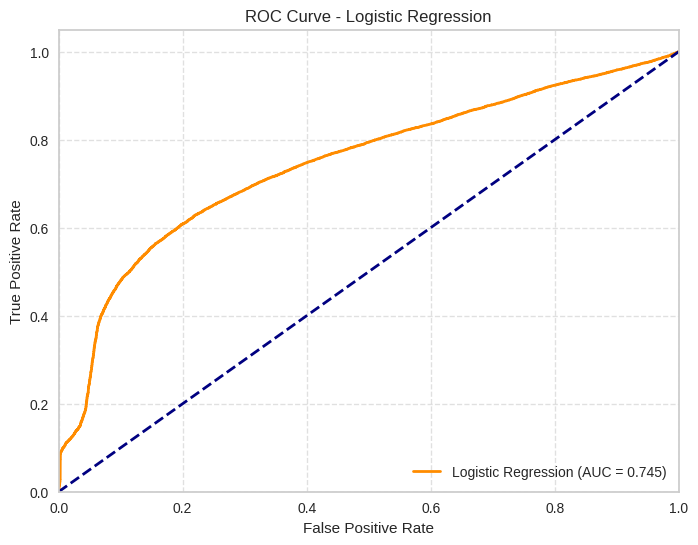

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    f1_score, roc_auc_score, log_loss, brier_score_loss,
    average_precision_score
)

def logistic_regression_classification(X_train, X_test, y_train, y_test, threshold=0.3):
    """
    Train Logistic Regression on pre-split and scaled data and evaluate.

    Parameters
    ----------
    X_train, X_test : np.array or pd.DataFrame
        Scaled feature matrices
    y_train, y_test : pd.Series or np.array
        Target variables
    threshold : float, optional (default=0.35)
        Decision threshold for classification.

    Returns
    -------
    dict
        Dictionary containing trained model, predictions, and evaluation metrics
    """
    # Train Logistic Regression
    model = LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)
    model.fit(X_train, y_train)

    # Predictions
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    # Evaluation metrics
    results = {
        'model': model,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'y_true': y_test,
        'threshold': threshold,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'log_loss': log_loss(y_test, y_proba),
        'brier_score': brier_score_loss(y_test, y_proba),
        'pr_auc': average_precision_score(y_test, y_proba)  # Precision-Recall AUC
    }

    # Print metrics
    print("LOGISTIC REGRESSION RESULTS ============================")
    print("Confusion Matrix:\n", results['confusion_matrix'])
    print("\nClassification Report:\n", results['classification_report'])
    print("Accuracy:", results['accuracy'])
    print("F1 Score:", results['f1_score'])
    print("ROC-AUC:", results['roc_auc'])
    print("Log Loss:", results['log_loss'])
    print("Brier Score:", results['brier_score'])
    print("PR-AUC:", results['pr_auc'])

    #ROC/AUC CURVE
    plot_roc_auc(results["y_true"], results["y_proba"], model_name="Logistic Regression")

    return results

lr_results = logistic_regression_classification(scaled_X_train, scaled_X_test, y_train, y_test, threshold=0.3)

In [ ]:
# install this if you donot have it
#!pip install yellowbrick

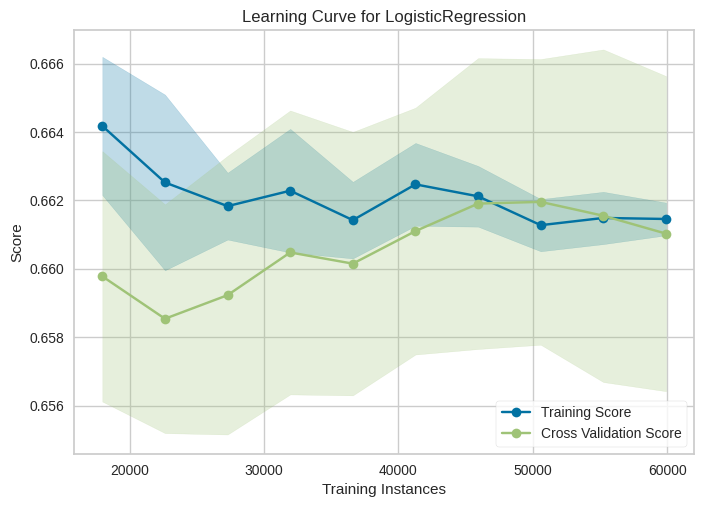

<Axes: title={'center': 'Learning Curve for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [ ]:
# LEARNING CURVE
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=7)
sizes = np.linspace(0.3, 1.0, 10)
visualizer = LearningCurve(
    lr_results['model'], cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)
#f1_weighted scoring metric is used to get a better sense of the relationship of precision and recall in our classifier.
visualizer.fit(scaled_X_train, y_train)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

## XGBOOST PIPELINE


XGBOOST MODEL RESULTS ============================
Confusion Matrix:
 [[ 8084  3873]
 [ 7932 18901]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.68      0.58     11957
           1       0.83      0.70      0.76     26833

    accuracy                           0.70     38790
   macro avg       0.67      0.69      0.67     38790
weighted avg       0.73      0.70      0.71     38790

Accuracy: 0.6956689868522815
F1 Score: 0.7620295522809281
ROC-AUC: 0.7423971055102633
Log Loss: 1.1088859357823573
Brier Score: 0.37688010527513055
PR-AUC: 0.8707701161211824


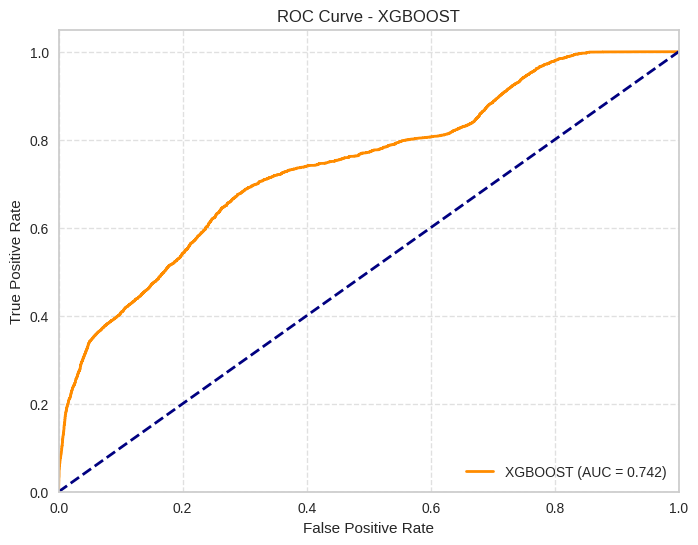

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, f1_score,
    roc_auc_score, log_loss, brier_score_loss, average_precision_score
)
import numpy as np

def xgb_classification_weighted(
    X_train, X_test, y_train, y_test,
    n_estimators=1000, max_depth=None, learning_rate=0.1,
    random_state=42, threshold=0.5, colsample_bytree=0.7, subsample=1.0):
    """
    Train a class-weighted XGBoost classifier and evaluate on test data.
    """

    # Handle class imbalance
    scale_pos_weight = np.sum(y_train == 0) / max(1, np.sum(y_train == 1))

    # Train model
    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        scale_pos_weight=scale_pos_weight,
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        random_state=random_state,
        eval_metric='logloss'
        )
    model.fit(X_train, y_train)

    # Predict probabilities
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    # Initialize results
    results = {
        'model': model,
        'y_pred': y_pred,
        'y_true': y_test,
        'y_proba': y_proba,
        'threshold': threshold,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, zero_division=0),
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred, zero_division=0),
        'feature_importances': model.feature_importances_
    }

    # Metrics that need both classes
    if y_test.nunique() > 1:
        results.update({
            'roc_auc': roc_auc_score(y_test, y_proba),
            'log_loss': log_loss(y_test, y_proba, labels=[0,1]),
            'brier_score': brier_score_loss(y_test, y_proba),
            'pr_auc': average_precision_score(y_test, y_proba)
        })
    else:
        results.update({
            'roc_auc': None,
            'log_loss': None,
            'brier_score': None,
            'pr_auc': None
        })
        print("⚠️ Warning: Only one class in y_test, skipped ROC-AUC, log_loss, brier, PR-AUC.")

    # Print metrics
    print("XGBOOST MODEL RESULTS ============================")
    print("Confusion Matrix:\n", results['confusion_matrix'])
    print("\nClassification Report:\n", results['classification_report'])
    print("Accuracy:", results['accuracy'])
    print("F1 Score:", results['f1_score'])
    if results['roc_auc'] is not None:
        print("ROC-AUC:", results['roc_auc'])
        print("Log Loss:", results['log_loss'])
        print("Brier Score:", results['brier_score'])
        print("PR-AUC:", results['pr_auc'])

    # ROC/AUC curve (only if both classes exist)
    if results['roc_auc'] is not None:
        plot_roc_auc(results["y_true"], results["y_proba"], model_name="XGBOOST")

    return results

xgb_results = xgb_classification_weighted(scaled_X_train, scaled_X_test, y_train, y_test, n_estimators=100, max_depth=3, learning_rate=0.1, threshold=0.145)

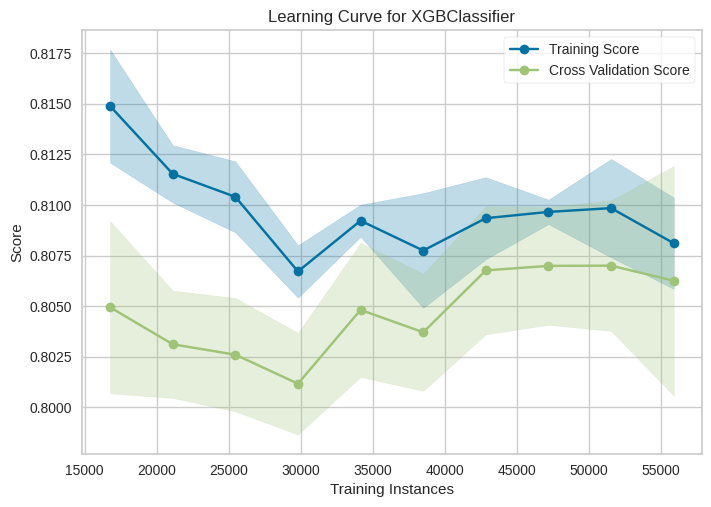

<Axes: title={'center': 'Learning Curve for XGBClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [ ]:
# LEARNING CURVE
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import StratifiedKFold
# Define CV and train sizes
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
sizes = np.linspace(0.3, 1.0, 10)
# Initialize the visualizer
visualizer = LearningCurve(xgb_results['model'],cv=cv,
    scoring='f1_weighted',train_sizes=sizes, n_jobs=4)
# Fit and render
visualizer.fit(scaled_X_train, y_train)
visualizer.show()

XGBOOST MODEL RESULTS ============================
Confusion Matrix:
 [[10151  1275]
 [ 1751  8559]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87     11426
           1       0.87      0.83      0.85     10310

    accuracy                           0.86     21736
   macro avg       0.86      0.86      0.86     21736
weighted avg       0.86      0.86      0.86     21736

Accuracy: 0.860783952889216
F1 Score: 0.8497815726767276
ROC-AUC: 0.9460746399511181
Log Loss: 0.30701503405826036
Brier Score: 0.09708223953402684
PR-AUC: 0.9453476115749089


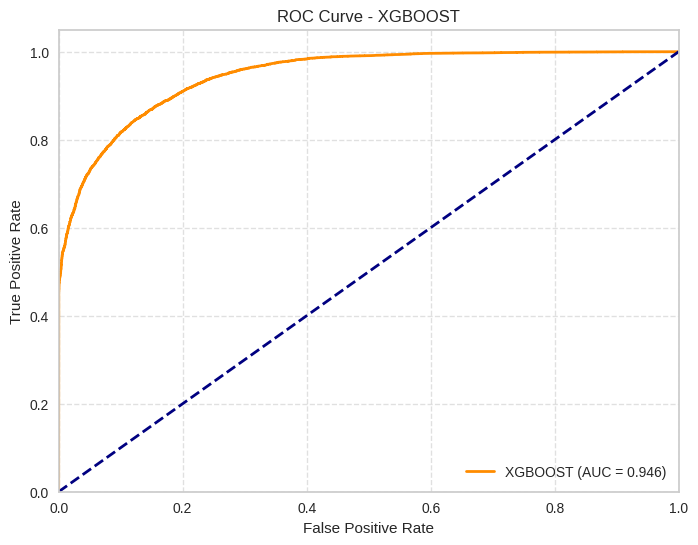

In [ ]:
# This model is trained with random split
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, f1_score,
    roc_auc_score, log_loss, brier_score_loss, average_precision_score
)
import numpy as np

def xgb_classification_weighted(
    X_train, X_test, y_train, y_test,
    n_estimators=1000, max_depth=None, learning_rate=0.1,
    random_state=42, threshold=0.5, colsample_bytree=0.7, subsample=1.0):
    """
    Train a class-weighted XGBoost classifier and evaluate on test data.
    """

    # Handle class imbalance
    scale_pos_weight = np.sum(y_train == 0) / max(1, np.sum(y_train == 1))

    # Train model
    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        scale_pos_weight=scale_pos_weight,
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        random_state=random_state,
        eval_metric='logloss'    )
    model.fit(X_train, y_train)

    # Predict probabilities
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    # Initialize results
    results = {
        'model': model,
        'y_pred': y_pred,
        'y_true': y_test,
        'y_proba': y_proba,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, zero_division=0),
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred, zero_division=0),
        'feature_importances': model.feature_importances_
    }

    # Metrics that need both classes
    if y_test.nunique() > 1:
        results.update({
            'roc_auc': roc_auc_score(y_test, y_proba),
            'log_loss': log_loss(y_test, y_proba, labels=[0,1]),
            'brier_score': brier_score_loss(y_test, y_proba),
            'pr_auc': average_precision_score(y_test, y_proba)
        })
    else:
        results.update({
            'roc_auc': None,
            'log_loss': None,
            'brier_score': None,
            'pr_auc': None
        })
        print("⚠️ Warning: Only one class in y_test, skipped ROC-AUC, log_loss, brier, PR-AUC.")

    # Print metrics
    print("XGBOOST MODEL RESULTS ============================")
    print("Confusion Matrix:\n", results['confusion_matrix'])
    print("\nClassification Report:\n", results['classification_report'])
    print("Accuracy:", results['accuracy'])
    print("F1 Score:", results['f1_score'])
    if results['roc_auc'] is not None:
        print("ROC-AUC:", results['roc_auc'])
        print("Log Loss:", results['log_loss'])
        print("Brier Score:", results['brier_score'])
        print("PR-AUC:", results['pr_auc'])

    # ROC/AUC curve (only if both classes exist)
    if results['roc_auc'] is not None:
        plot_roc_auc(results["y_true"], results["y_proba"], model_name="XGBOOST")

    return results

xgb_results = xgb_classification_weighted(scaled_X_train, scaled_X_test, y_train, y_test, n_estimators=100, max_depth=3, learning_rate=0.1, threshold=0.5)

## LightGBM PIPELINE

[LightGBM] [Info] Number of positive: 24714, number of negative: 45174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2999
[LightGBM] [Info] Number of data points in the train set: 69888, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LIGHTGBM MODEL RESULTS ============================
Confusion Matrix:
 [[ 7080  4877]
 [ 8047 18786]]

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.59      0.52     11957
           1       0.79      0.70      0.74     26833

    accuracy                           0.67     38790
   macro avg       0.63      0.65      0.63     38790
weighted avg       0.69      0.67      0.68     38790

Accuracy: 0.6668213457076566
F1 Score: 0.7440589353612

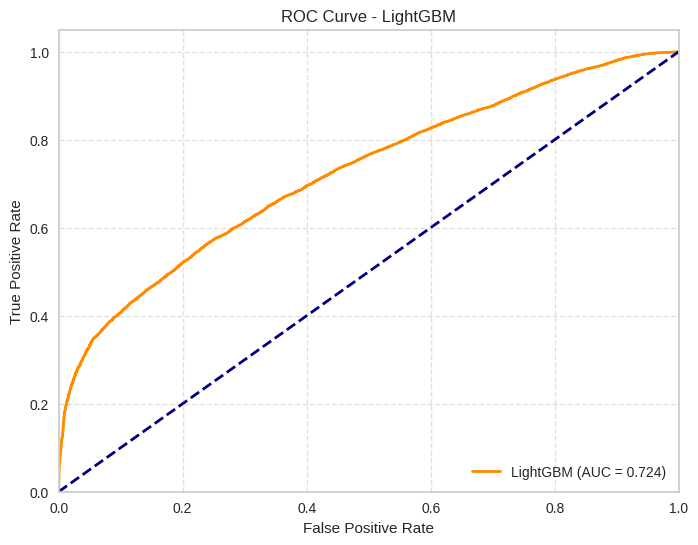

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, f1_score,
    roc_auc_score, log_loss, brier_score_loss, average_precision_score
)
import numpy as np

def lgbm_classification_weighted(
    X_train, X_test, y_train, y_test,
    n_estimators=1000, max_depth=-1, learning_rate=0.1,
    random_state=42, threshold=0.05, colsample_bytree=0.7, subsample=1.0, num_leaves=31):
    """
    Train a class-weighted LightGBM classifier and evaluate on test data.
    """

    # Handle class imbalance
    scale_pos_weight = np.sum(y_train == 0) / max(1, np.sum(y_train == 1))

    # Train model
    model = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        class_weight={0: 1, 1: scale_pos_weight},  # balancing classes
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        num_leaves=num_leaves,
        random_state=random_state
    )
    model.fit(X_train, y_train)

    # Predict probabilities
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    # Initialize results
    results = {
        'model': model,
        'y_pred': y_pred,
        'y_true': y_test,
        'y_proba': y_proba,
        'threshold': threshold,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, zero_division=0),
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred, zero_division=0),
        'feature_importances': model.feature_importances_
    }

    # Metrics that need both classes
    if y_test.nunique() > 1:
        results.update({
            'roc_auc': roc_auc_score(y_test, y_proba),
            'log_loss': log_loss(y_test, y_proba, labels=[0, 1]),
            'brier_score': brier_score_loss(y_test, y_proba),
            'pr_auc': average_precision_score(y_test, y_proba)
        })
    else:
        results.update({
            'roc_auc': None,
            'log_loss': None,
            'brier_score': None,
            'pr_auc': None
        })
        print("⚠️ Warning: Only one class in y_test, skipped ROC-AUC, log_loss, brier, PR-AUC.")

    # Print metrics
    print("LIGHTGBM MODEL RESULTS ============================")
    print("Confusion Matrix:\n", results['confusion_matrix'])
    print("\nClassification Report:\n", results['classification_report'])
    print("Accuracy:", results['accuracy'])
    print("F1 Score:", results['f1_score'])
    if results['roc_auc'] is not None:
        print("ROC-AUC:", results['roc_auc'])
        print("Log Loss:", results['log_loss'])
        print("Brier Score:", results['brier_score'])
        print("PR-AUC:", results['pr_auc'])

    # ROC/AUC curve (only if both classes exist)
    if results['roc_auc'] is not None:
        plot_roc_auc(results["y_true"], results["y_proba"], model_name="LightGBM")

    return results


# Example run
lgbm_results = lgbm_classification_weighted(
    scaled_X_train, scaled_X_test, y_train, y_test,
    n_estimators=100, max_depth=-1, learning_rate=0.1, threshold=0.05
)

## COMPARING MODELS' PERFORMANCE AND EVALUATION METRICS

Following metrics are used to evaluate the models built.
- **Log Loss & Brier Score → Calibration**  
  Show how well predicted probabilities match actual outcomes (lower = better).  

- **ROC-AUC & PR-AUC → Ranking Quality**  
  Measure overall ability to separate discontinued vs retained products, across all thresholds.  

- **F1, Recall & Confusion Matrix → Threshold-Dependent Trade-offs**  
  At chosen thresholds (e.g., 0.3 for Logistic Regression, 0.145 for XGBoost, 0.05 for LightGBM), these metrics show the balance between catching discontinued items (recall) and avoiding false alarms.  

✅ Together, these metrics evaluate **probability trustworthiness, ranking quality, and decision trade-offs** for product discontinuation.  


In [ ]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, f1_score, recall_score

def build_model_comparison_table(results_dict):
    """
    Build comparison table of model evaluation metrics using y_pred from models.
    Also displays threshold used for each model (if provided).

    Parameters:
    -----------
    results_dict : dict
        Dictionary of results dicts, e.g. {"LR": lr_results, "XGB": xgb_results}
        Each result dict must contain: y_true, y_pred, y_proba, and optionally "threshold".

    Returns:
    --------
    pd.DataFrame
        Summary table of model metrics
    """
    rows = []
    for model_name, res in results_dict.items():
        y_true = res["y_true"]
        y_pred = res["y_pred"]   # directly from model
        y_proba = res["y_proba"]

        # Confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        row = {
            "Model": model_name,
            "Threshold": res.get("threshold"),  # add threshold if stored
            "Log Loss": round(res.get("log_loss", float("nan")), 4),
            "Brier Score": round(res.get("brier_score", float("nan")), 4),
            "ROC-AUC": round(res.get("roc_auc", float("nan")), 4),
            "PR-AUC": round(res.get("pr_auc", float("nan")), 4),
            "F1": round(f1_score(y_true, y_pred, zero_division=0), 4),
            "Recall": round(recall_score(y_true, y_pred, zero_division=0), 4),
            "Confusion Matrix": f"TN={tn}, FP={fp}, FN={fn}, TP={tp}"
        }
        rows.append(row)

    df_summary = pd.DataFrame(rows)

    # --- Pretty Plotly Table ---
    fig = go.Figure(
        data=[go.Table(
            header=dict(values=list(df_summary.columns),
                        fill_color='royalblue',
                        align='center',
                        font=dict(color='white', size=12)),
            cells=dict(values=[df_summary[col] for col in df_summary.columns],
                       fill_color=[['lightgray','white'] * (len(df_summary)//2 + 1)],
                       align='center'))
        ]
    )
    fig.update_layout(title="📊 Model Comparison Table", title_x=0.5)
    fig.show()

    return df_summary


# === Example Run ===
results_dict = {
    "Logistic Regression": lr_results,  # {"threshold": 0.3} if default
    "XGBoost": xgb_results,             # {"threshold": 0.145}
    "LightGBM": lgbm_results,           # {"threshold": 0.05}
}

comparison_df = build_model_comparison_table(results_dict)

### 🔎 Interpretation of Key Metrics

### 🔹 F1 Score (overall balance)

- **Logistic Regression (0.7678)** is slightly higher than **XGBoost (0.7620)** and **LightGBM (0.7441)**.  
- This means Logistic Regression gives the **best balance between precision & recall**.  

---

### 🔹 Recall (catching discontinued products)

- **Logistic Regression (0.7223)** is again slightly ahead of **XGBoost (0.7044)** and **LightGBM (0.7001)**.  
- Recall = fewer **false negatives** (i.e., fewer discontinued products missed).  

👉 **Important because:** Missing discontinued products (FN) leads to overstocking dead stock — costly in retail.  

---

### 🔹 Probability Calibration (Log Loss & Brier Score)

- **Logistic Regression** has the **lowest Log Loss (0.8455)** and **Brier Score (0.312)** → better calibrated probabilities.  
- **LightGBM** performs worst here (Log Loss = 1.4575).  

👉 **Why important?**  
If probabilities are used in decision rules (e.g., drop products with >80% discontinuation risk), calibration matters.  

---

### 🔹 Ranking Ability (ROC-AUC & PR-AUC)

- All models are similar: **ROC-AUC ~0.72–0.75**, **PR-AUC ~0.86–0.87**.  
- Logistic Regression has a **tiny edge in ROC-AUC**, while XGBoost has a **slight edge in PR-AUC**.  

---

### 🔹 Confusion Matrix

- **Logistic Regression** catches the most **true positives (TP = 19,381)** while keeping **false negatives lower (FN = 7,452)**.  
- XGBoost and LightGBM miss slightly more discontinued products (**higher FN**).  

---

## ✅ Best Model to Implement

**Logistic Regression (Threshold = 0.3)** looks like the best overall choice:  

- **Highest F1 (0.7678)** → best balance.  
- **Highest Recall (0.7223)** → fewer missed discontinued products (**critical for business**).  
- **Best calibration** (lowest Log Loss & Brier) → trustworthy probability estimates.  
- **Competitive AUCs** → no disadvantage in global ranking.  

---

## 📌 Recommendation for Business Use

- ✅ **Implement Logistic Regression (thr=0.3)** as the **baseline** → simple, interpretable, strong performance.  
- ⚡ **Keep XGBoost (thr=0.145)** as a **backup** for more complex patterns (slightly higher PR-AUC, fewer false positives).  
- ❌ **Avoid LightGBM (thr=0.05)** in current form → weaker calibration and recall.  

👉 **Next step:** Perform **threshold tuning per model** to maximize business-specific cost function (e.g., assign higher penalty to FN than FP).  


## BRIER SCORE PLOT

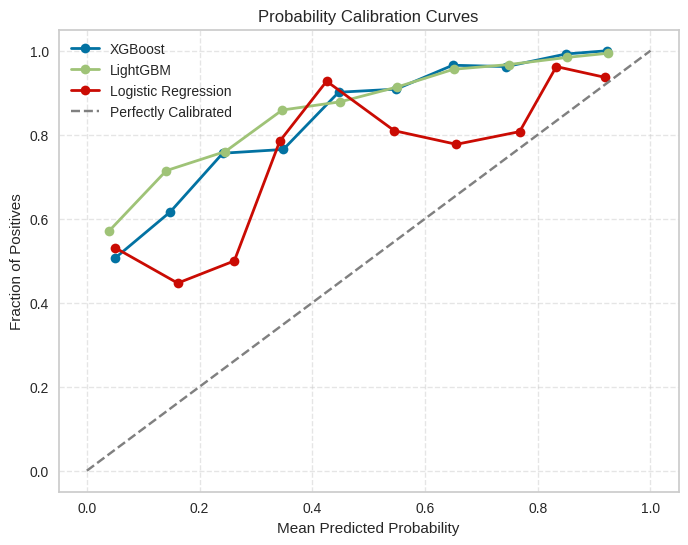

In [ ]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

def plot_calibration_curves(models_probs: dict, y_true, n_bins=10, title="Probability Calibration Curves"):
    """
    Plot calibration curves (reliability diagrams) for multiple models.

    Parameters
    ----------
    models_probs : dict
        Dictionary where keys are model names and values are predicted probabilities.
        e.g., {'XGBoost': xgb_results['y_proba'], 'Random Forest': rf_results['y_proba']}
    y_true : array-like
        True target values (0/1).
    n_bins : int
        Number of bins for calibration curve.
    title : str
        Title of the plot.
    """
    plt.figure(figsize=(8, 6))

    # Plot calibration for each model
    for model_name, y_proba in models_probs.items():
        prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=n_bins, strategy='uniform')
        plt.plot(prob_pred, prob_true, marker='o', label=model_name, linewidth=2)

    # Perfectly calibrated line
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


models_probs_dict = {
    "XGBoost": xgb_results['y_proba'],
    "LightGBM": lgbm_results['y_proba'],
    "Logistic Regression": lr_results['y_proba']
}

plot_calibration_curves(models_probs_dict, y_test, n_bins=10)


## FEATURE IMPORTANCE

In [ ]:
import pandas as pd
import plotly.express as px

# --- Get feature importances from trained RF model ---
xgb_model = xgb_results["model"]

importances = xgb_model.feature_importances_
features = scaled_X_train.columns

# Create DataFrame
feat_imp = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# --- Plotly Express Bar Chart ---
fig = px.bar(
    feat_imp,
    x="importance",
    y="feature",
    orientation="h",
    title="Random Forest Feature Importance",
    color="importance",
    color_continuous_scale="Blues"
)

# Show highest importance at the top + increase height
fig.update_layout(
    yaxis=dict(autorange="reversed"),
    xaxis_title="Importance",
    yaxis_title="Feature",
    height=1000
)

fig.show()

## SHAP - EXPLANABILITY

In [ ]:
# !pip install shap

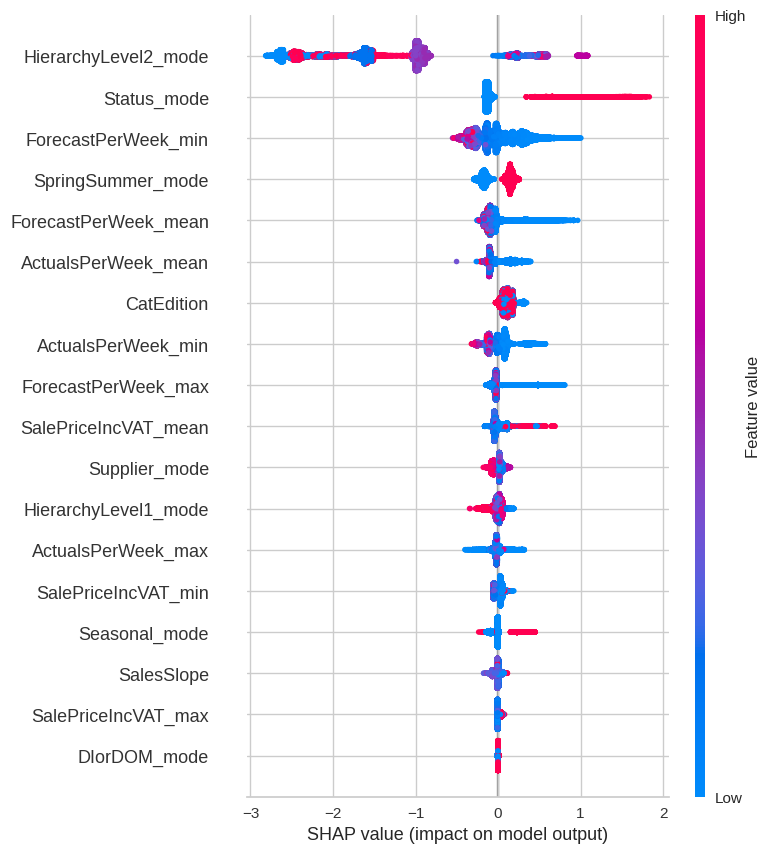

In [ ]:
import numpy as np
import shap

# Train your model (assuming xgb_model is already trained)
explainer = shap.Explainer(xgb_results['model'])
# Get SHAP values
shap_values = explainer.shap_values(scaled_X_test)
# Visualize
shap.summary_plot(shap_values, scaled_X_test)

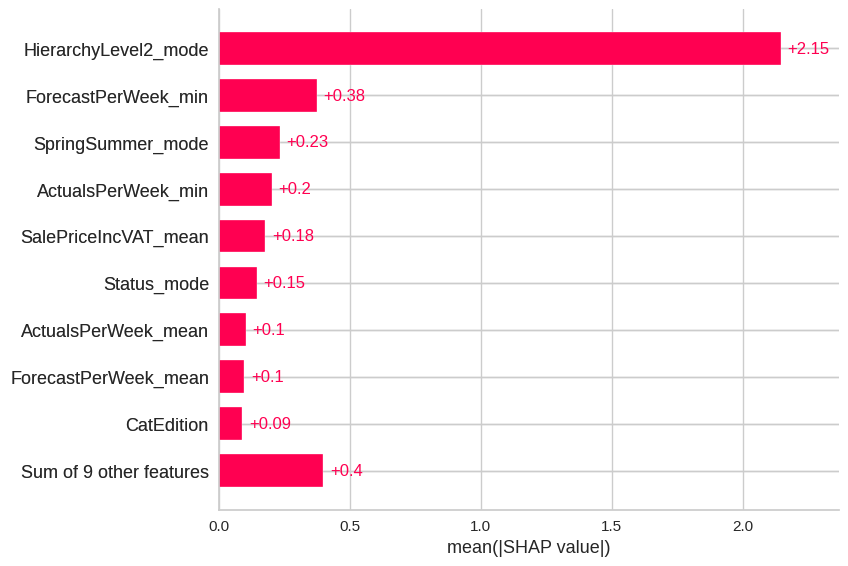

In [ ]:
# Calculate SHAP values
shap_values = explainer(X_test)

# Plot feature importance using a bar chart
shap.plots.bar(shap_values)

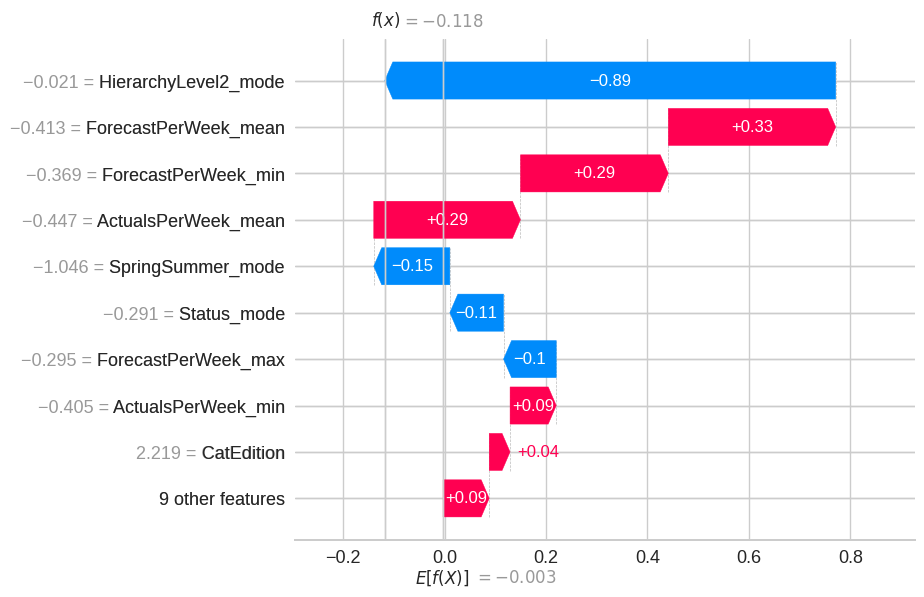

In [ ]:
# SHAP Explainer
shap_values = explainer(scaled_X_test)

# Waterfall plot for the first observation
shap.waterfall_plot(shap_values[0])

## COST-BASED THRESHOLD

### **Business Interpretation of Cost-Based Threshold**

When predicting whether a product will be **discontinued** at the next Argos catalogue refresh,  
our model outputs a **probability** between 0 and 1:

- **High probability** → more likely to be discontinued.  
- **Low probability** → more likely to be retained.  

By default, many models use a **0.5 threshold**:  
- If probability ≥ 0.5 → predict **Discontinue**.  
- If probability < 0.5 → predict **Keep**.  

However, in our case, **misclassification errors have different business costs**:

| Error Type              | Meaning                                           | Business Impact                |
|--------------------------|---------------------------------------------------|--------------------------------|
| **False Positive (FP)**  | Predicted “Discontinue” but the product **continues** | Lost sales and profit          |
| **False Negative (FN)**  | Predicted “Keep” but the product **discontinues** | Clearance and markdown costs   |

Because the **cost of wrong decisions** is not equal, we adjust the decision threshold to **minimize total financial loss**, not just maximize accuracy.

---

### **Optimal Threshold Result**

- **Optimal threshold:** **0.15**  
  This means:
  - Products with a predicted discontinuation probability **≥ 15%** → classified as **Discontinue**.  
  - Products with a predicted discontinuation probability **< 15%** → classified as **Keep**.  

- **Expected minimum cost:** **~£707,090 per catalogue refresh**  
  This is the estimated combined cost of clearance losses and lost sales when using the optimal threshold.

---

### **Why It Matters**

Using the default **0.5 threshold**:  
- We make more wrong decisions.  
- Expected business cost is **higher**.  

Using the **optimized 0.15 threshold**:  
- We reduce expected financial loss to **~£707,090**.  
- This demonstrates clear **financial benefit** from threshold optimization.  

---

### **Key Takeaways**
- **Accuracy ≠ Business Value** → Optimizing for financial cost gives better outcomes.  
- **Threshold tuning aligns the model with real business priorities.**  
- This approach **reduces both clearance losses and lost sales**, directly improving profitability.  


In [ ]:
import numpy as np

def best_threshold_cost(y_true, y_prob, cost_fp, cost_fn):
    """
    Finds the decision threshold that minimizes expected business cost.
    """
    thresholds = np.linspace(0.01, 0.99, 99)
    best_t, best_cost = 0.5, np.inf
    costs = []

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        fp = ((y_true == 0) & (y_pred == 1)).sum()
        fn = ((y_true == 1) & (y_pred == 0)).sum()
        cost = cost_fp * fp + cost_fn * fn
        costs.append((t, cost))
        if cost < best_cost:
            best_t, best_cost = t, cost

    return best_t, best_cost, costs

# Example: assume costs per SKU
COST_FP = 80   # lost sales if we wrongly discontinue a good product
COST_FN = 50   # clearance cost if we wrongly keep a bad product

t_star, min_cost, costs = best_threshold_cost(y_test.values, xgb_results['y_proba'], COST_FP, COST_FN)

print(f"Optimal Threshold = {t_star:.2f}")
print(f"Expected Minimum Cost per Evaluation = £{min_cost:,.0f}")


Optimal Threshold = 0.15
Expected Minimum Cost per Evaluation = £707,090


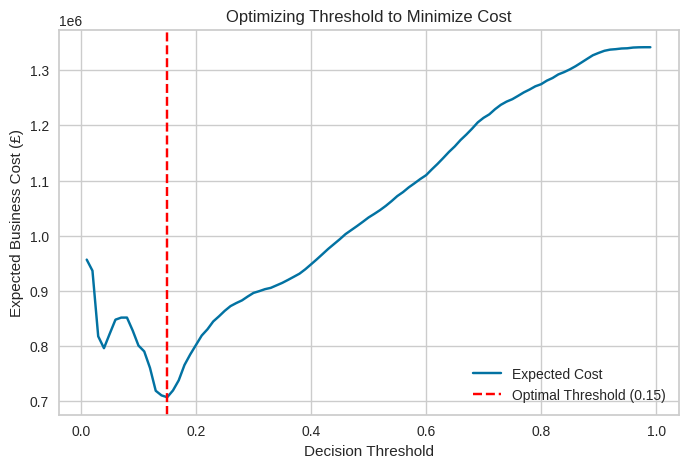

In [ ]:
import matplotlib.pyplot as plt

thresholds, total_costs = zip(*costs)

plt.figure(figsize=(8,5))
plt.plot(thresholds, total_costs, label="Expected Cost")
plt.axvline(t_star, color="red", linestyle="--", label=f"Optimal Threshold ({t_star:.2f})")
plt.xlabel("Decision Threshold")
plt.ylabel("Expected Business Cost (£)")
plt.title("Optimizing Threshold to Minimize Cost")
plt.legend()
plt.show()

## DEPLOYMENT - TEST CASE

In [ ]:
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# --- FEATURES AND TARGET ---
X = df.drop(columns=['Target_Next', 'ProductKey'])
y = df['Target_Next']

# --- SAVE COLUMNS AS .pkl FOR INFERENCE ---
print(X.columns)
pickle.dump(list(X.columns), open("Xcolumns.pkl", "wb"))

# --- SCALE X (fit once on raw features) ---
scaler = StandardScaler()
X = scaler.fit_transform(X)

# --- SAVE SCALER ---
pickle.dump(scaler, open("scaler.pkl", "wb"))

# --- MODEL TO DEPLOY ---
logreg_model_to_deploy = LogisticRegression(
    class_weight="balanced",
    max_iter=5000,
    random_state=42
)

# --- TRAIN MODEL ---
logreg_model_to_deploy.fit(X, y)

# --- CHOSEN THRESHOLD ---
chosen_threshold = 0.3

# --- SAVE MODEL + THRESHOLD AS pkl ---
model_package = {
    "model": logreg_model_to_deploy,
    "threshold": chosen_threshold
}

with open("logreg_model_to_deploy.pkl", "wb") as file:
    pickle.dump(model_package, file)

print("✅ Model, threshold, scaler, and feature columns saved successfully!")

Index(['CatEdition', 'SalePriceIncVAT_mean', 'SalePriceIncVAT_min',
       'SalePriceIncVAT_max', 'ForecastPerWeek_mean', 'ForecastPerWeek_min',
       'ForecastPerWeek_max', 'ActualsPerWeek_mean', 'ActualsPerWeek_min',
       'ActualsPerWeek_max', 'Supplier_mode', 'HierarchyLevel1_mode',
       'HierarchyLevel2_mode', 'DIorDOM_mode', 'Seasonal_mode',
       'SpringSummer_mode', 'Status_mode', 'SalesSlope'],
      dtype='object')
✅ Model, threshold, scaler, and feature columns saved successfully!


In [ ]:
# LOAD ARTIFACTS
import pickle
# --- LOAD MODEL + THRESHOLD ---
saved_package = pickle.load(open("logreg_model_to_deploy.pkl", "rb"))
saved_logreg_model = saved_package["model"]
saved_threshold = saved_package["threshold"]

# --- LOAD SCALER ---
saved_scaler = pickle.load(open("scaler.pkl", "rb"))

# --- LOAD TRAINING COLUMNS ---
train_cols = pickle.load(open("Xcolumns.pkl", "rb"))

# SAMPLE DATA TO TEST
sample_product = {
    'CatEdition': 92, 'SalePriceIncVAT_mean': 29.99, 'SalePriceIncVAT_min': 29.99, 'SalePriceIncVAT_max': 29.99,
    'ForecastPerWeek_mean': 12.5, 'ForecastPerWeek_min': 5.0, 'ForecastPerWeek_max': 25.0,
    'ActualsPerWeek_mean': 11.8, 'ActualsPerWeek_min': 6.0, 'ActualsPerWeek_max': 20.0,
    'Supplier_mode': 662, 'HierarchyLevel1_mode': 60, 'HierarchyLevel2_mode': 11,
    'DIorDOM_mode': 1,          # e.g., 1 = DOM, 0 = DI
    'Seasonal_mode': 0,         # e.g., 0 = Non-seasonal
    'SpringSummer_mode': 1,     # e.g., 1 = Spring/Summer
    'Status_mode': 0,           # encoded status value
    'SalesSlope': -0.035        # negative slope = declining sales
}

#CONVERT TO DF
sample_data_df = pd.DataFrame([sample_product])

# ENSURE COLUMNS
sample_data_df = sample_data_df[train_cols]

# --- SCALE NEW SAMPLE ---
scaled_sample_data_df = saved_scaler.transform(sample_data_df)

# --- PREDICT PROBABILITY ---
proba = saved_logreg_model.predict_proba(scaled_sample_data_df)[:, 1]

# --- APPLY SAVED THRESHOLD ---
pred = (proba >= saved_threshold).astype(int)

print("Predicted probability of the Positive Class (Discontinued):", proba[0])
print("Predicted class (0 = Retained, 1 = Discontinued):", pred[0])

Predicted probability of the Positive Class (Discontinued): 0.7187361464605941
Predicted class (0 = Retained, 1 = Discontinued): 1


## 🔮 FUTURE ROADMAP FOR THE PROJECT

### 1. Data Improvements
- **Expand Features**  
  - Include product age (how many catalogue editions it survived).  
  - Add relative sales performance (e.g., sales vs. category average).  
  - Incorporate supplier-level signals (historical discontinuation patterns).  
- **External Data**  
  - Integrate market trends, competitor pricing, or seasonal effects.  
  - Enrich with promotional data (discounts, campaigns).  

### 2. Feature Engineering
- Explore **lagged features** (e.g., moving averages of sales/forecast).  
- Add **interaction terms** (price × forecast, supplier × season).  
- Use **time-series decomposition** to capture seasonality and trends.  

### 3. Model Enhancements
- Benchmark additional algorithms:  
  - **CatBoost** (handles categorical features well).  
  - **Random Forest** as a simpler ensemble baseline.  
  - **Neural Networks** for capturing nonlinearities.  
- Conduct **hyperparameter tuning** with Optuna or Bayesian Optimization.  
- Build **ensemble models** (stacking LR + XGBoost + CatBoost).  

### 4. Threshold Optimization
- Move beyond a fixed threshold (0.3, 0.15, etc.).  
- Optimize thresholds with **cost-sensitive metrics**, reflecting real business costs:  
  - FP = lost sales.  
  - FN = clearance/markdown costs.  

### 5. Model Validation
- Use **walk-forward validation** across catalogues for robust testing.  
- Track **concept drift** over time (changes in customer/supplier behavior).  
- Build a **monitoring pipeline** for live model performance.  

### 6. Deployment & MLOps
- Package model, scaler, and threshold into a **pipeline API**.  
- Deploy via Flask/FastAPI on cloud (AWS/GCP/Azure).  
- Implement **scheduled retraining** (e.g., after each catalogue refresh).  
- Add **explainability tools** (e.g., SHAP) for stakeholder trust.  

### 7. Business Integration
- Create **dashboards** (Power BI, Tableau, Streamlit) for merchandising teams.  
- Simulate **what-if scenarios** (e.g., "If price drops 10%, does discontinuation risk change?").  
- Provide **actionable recommendations**: which products to keep, cut, or review.  

### 8. Long-Term Vision
- Transition from binary classification (retain/discontinue) to:  
  - **Multiclass outcomes** (retain, discontinue, replace, promote).  
  - **Survival analysis** (predict *time-to-discontinuation*).  
- Incorporate **reinforcement learning** for dynamic product range optimization.  

---

✅ This roadmap ensures the project evolves from a **predictive prototype** to a **production-ready decision support system**, tightly aligned with Argos’ business strategy.
